In [6]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import poisson
from pathos.multiprocessing import ProcessingPool as Pool
import pickle
import matplotlib.gridspec as gridspec
from scipy.interpolate import UnivariateSpline
from PIL import Image

plt.style.use('pcb')

In [7]:
with open('data/voltage_current_abstract.pickle','rb') as file:
    data_current = pickle.load(file)

with open('data/voltage_whitenoise_abstract.pickle','rb') as file:
    data_whitenoise = pickle.load(file)

with open('data/voltage_conductance_abstract_inh_40kHz.pickle','rb') as file:
    data_conductance = pickle.load(file)

In [8]:
with open('data/HH_clas_abstract.pickle','rb') as file:
    data_hh_clas = pickle.load(file)

with open('data/HH_musc_abstract.pickle','rb') as file:
    data_hh_musc = pickle.load(file)

with open('data/HH_dynt_abstract.pickle','rb') as file:
    data_hh_dynt = pickle.load(file)

In [9]:
def plot_input(data, ax):
    skip = 100

    tarr, varr, *_ = data['run']
    average = data['average']
    std = data['std']
    
    mask = (tarr-100 > 0) & (tarr - 100 <= 2000)

    ax.plot(tarr[mask]-100, varr[mask])
    ax.plot(tarr[mask][::skip]-100, average[mask][::skip], color='black', lw=3)
    ax.plot(tarr[mask][::skip]-100, average[mask][::skip]+std[mask][::skip], color='red', linestyle='dotted', lw=3)
    ax.plot(tarr[mask][::skip]-100, average[mask][::skip]-std[mask][::skip], color='red', linestyle='dotted', lw=3)
    
    ax.set_xlim(0,2000)
    ax.set_ylim(varr[mask].min(), varr[mask].max())

In [10]:
def plot_hh(data, gs, title=None):
    ax1 = fig.add_subplot(gs[:3])
    ax2 = fig.add_subplot(gs[3:5])
    ax3 = fig.add_subplot(gs[5:])

    tarr, varr = data['run']
    counts = data['average']
    std = data['std']
    
    ax1.set_title(title, loc='left')
    ax1.plot(tarr-1000, varr, color='black')
    ax1.set_xlim(0,2000)
    ax1.set_xticks([])
    ax2.set_xticks([])
    ax2.plot(10*counts, color='C0')
    ax3.plot(std**2 / counts, color='C1')
    ax3.set_xticks([0, 25, 50, 75, 100])
    ax3.set_xticklabels([0, 500, 1000, 1500, 2000])
    ax3.set_xlabel(r'$\mathrm{time\,(ms)}$')
#     ax3.set_ylim(0.05, 0.6)
#     ax3.set_yticks([0.1, 0.3, 0.5])

    for ax in [ax1, ax2, ax3]:
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(ax.is_last_row())
        ax.spines['right'].set_visible(False)
    
    return [ax1, ax2, ax3]

In [12]:
def plot_voltage(data, axes):
    def lami_func(t):
        return 20*(1 - 1 / (1 + np.exp((t-1100) / 50)))

    T = 2100 # 5 -> 30
    t = 0
    dt = 0.01

    tt = np.arange(0, T, dt)
    
    axes[0].plot(tt-100, lami_func(tt), color='black')
    axes[0].spines['bottom'].set_visible(False)
    axes[0].set_xticks([])
    axes[0].set_yticks([0, 20])
    
    tarr, varr, iarr = data['run']
    
    axes[1].plot(tarr-100, iarr)
    axes[1].spines['bottom'].set_visible(False)
    axes[1].set_xticks([])
    
    skipstep = 1000
    
    average = data['average_i']
    std = data['std_i']
    std = pd.Series(data['std_i']).rolling(window=skipstep, center=True).mean().values
    xx = tarr-100
    yy = average-std
#     func = UnivariateSpline(xx[::skipstep], yy[::skipstep], s=0.2, k=3)
#     axes[1].plot(xx, func(xx), color='C1', lw=2)
    lw = 2

    axes[1].plot(xx[::skipstep], yy[::skipstep], color='C1', lw=lw)
    yy = average+std
    axes[1].plot(xx[::skipstep], yy[::skipstep], color='C1', lw=lw)
#     axes[1].fill_between(tarr-100, average-std, average+std, alpha=0.8, color='C1')
    
    axes[2].plot(tarr-100, varr)
    
    average = data['average']
    std = data['std']
    std = pd.Series(data['std']).rolling(window=skipstep, center=True).mean().values
    xx = tarr-100
    yy = average-std
    axes[2].plot(xx[::skipstep], yy[::skipstep], color='C1', lw=lw)
    yy = average+std
    axes[2].plot(xx[::skipstep], yy[::skipstep], color='C1', lw=lw)
    axes[2].set_ylim(-56,-44)
    
    
    axes[0].set_title(r'${\bf A:}\ \ \mathrm{Inhibition\ increase}$', loc='left')
    axes[1].set_title(r'${\bf B:}\ \ \mathrm{Non-spiking\ membrane}$' + '\n' + r'$\mathrm{Synaptic\ current}$', loc='left')
    axes[2].set_title(r'$\mathrm{Membrane\ potential}$', loc='left')
    
    for ax in axes:
        ax.set_xlim(0,2000)

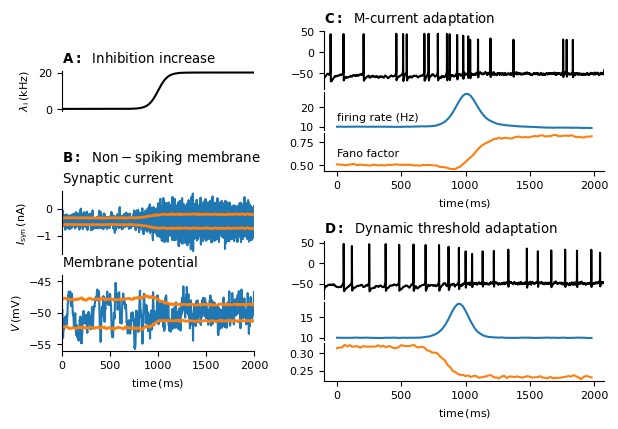

In [13]:
fig = plt.figure(figsize=(7., 4))
gs_inh = fig.add_gridspec(1,1,top=0.9, bottom=0.8, right=0.4)

ax = fig.add_subplot(gs_inh[0])
gs_voltage = fig.add_gridspec(nrows=2, ncols=1, right=0.4, top=0.6, bottom=0.2, height_ratios=[2.5,3], hspace=0.3)

axes = [ax] + [fig.add_subplot(gs_voltage[i]) for i in range(2)]
axes[0].set_ylabel(r'$\lambda_\mathrm{i}\,\mathrm{(kHz)}$')
axes[1].set_ylabel(r'$I_\mathrm{syn}\,\mathrm{(nA)}$')
axes[2].set_ylabel(r'$V\,\mathrm{(mV)}$')
axes[2].set_xlabel(r'$\mathrm{time\,(ms)}$')


plot_voltage(data_conductance, axes)


grid_hh = fig.add_gridspec(2, 1, wspace=0, hspace=0.5, left=0.5, top=1)

inner_hh2 = gridspec.GridSpecFromSubplotSpec(7, 1, grid_hh[0])
axes = plot_hh(data_hh_musc, inner_hh2, title=r'${\bf C:}$' + '  M-current adaptation')
axes[1].text(x=0, y=13, s='firing rate (Hz)')
axes[2].text(x=0, y=0.6, s='Fano factor')

inner_hh3 = gridspec.GridSpecFromSubplotSpec(7, 1, grid_hh[1])
axes = plot_hh(data_hh_dynt, inner_hh3, title=r'${\bf D:}$' + '  Dynamic threshold adaptation')
# axes[2].set_yticks([.25,.3])
# axes[2].set_ylim([.19,.34])

plt.savefig('img/visual_abstract.png')